# Pennylane-Braket で勾配の並列計算

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Amazon Braket SV1 シミュレーターの特徴は、PennyLane から送信された複数の回路を並行して実行できることです。これは、各トレーニングステップで実行する必要がある回路のバリエーションが多数作成される、スケーラブルな最適化に不可欠です。 

このチュートリアルでは、この機能の重要性を説明し、自分でベンチマークする方法を説明します。

## なぜ回路の訓練コストがそれほど高いのか？

量子回路の量子古典ハイブリッド最適化は、短期的な量子コンピューティング応用における主力アルゴリズムです。変分量子回路を訓練するための基礎であるだけでなく、量子化学計算、量子機械学習、そしてもちろん素の量子最適化ためのより広い応用も考えられます。今日の最も強力な最適化アルゴリズムは、勾配の効率的な計算に依存しています。これは、アルゴリズムの出力を改善するためにパラメータを少しずつ微調整する方法を示してくれます。 

量子回路の訓練は大変です！最適化の各ステップでは、回路勾配の評価が必要です。勾配の計算には、複数のデバイス実行が必要です。通常、トレーニング可能なパラメータごとに、デバイス上で回路を [複数回](https://pennylane.ai/qml/glossary/parameter_shift.html) 実行する必要があります。合理的なアプリケーションには、多くのトレーニング可能なパラメータが含まれます (何百万もの調整可能な重みを持つ古典的なニューラルネットを考えてみてください)。その結果、最適化ステップごとに膨大な数のデバイスが実行されることになります。


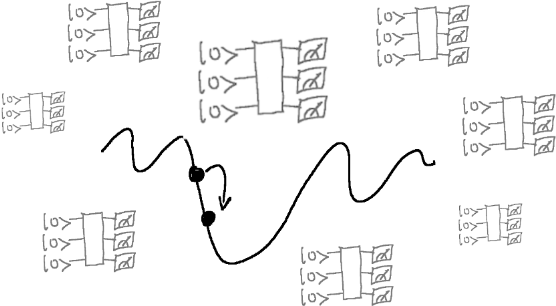

``braket.local.qubit`` デバイスでは、勾配はデバイスの逐次実行を通じて PennyLane で計算されます。言い換えると、これらの回路はすべて、評価されるまで同じキューで待機する必要があります。このアプローチは簡単ですが、パラメータの数をスケールするとすぐに遅くなります。さらに、回路の量子ビット数、か「幅」が増えると、各デバイスの実行速度が低下し、最終的には顕著なボトルネックになります。要するに、**量子回路のトレーニングの未来は、高性能のリモートシミュレータと高度に並列化されたハードウェアデバイスに依存している** とも言えます。 

幸いなことに、Amazon Braket は SV1 シミュレータを使用したスケーラブルな量子回路の訓練方法を提供します。SV1 シミュレータは、並列実行を念頭に置いて設計された、高性能な状態ベクトルシミュレータです。PennyLane と一緒に SV1 を使用して、勾配の計算に必要なすべての回路を並列に実行できます。

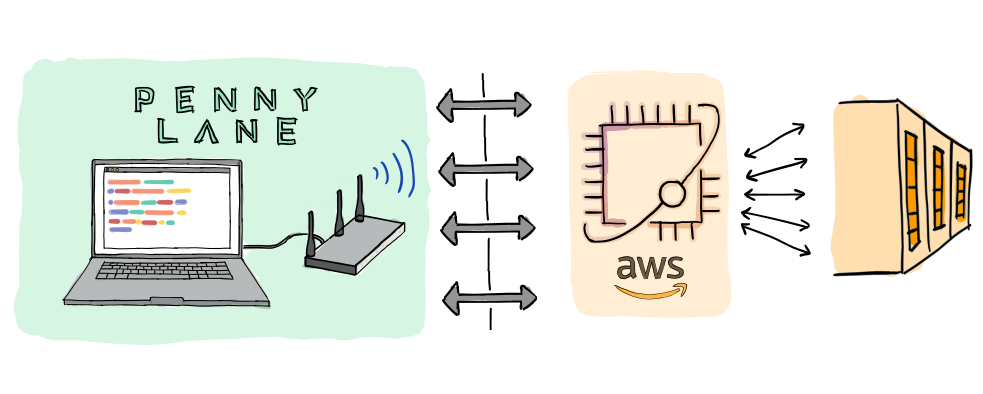

## SV1 デバイスの読み込み

Braket の SV1 シミュレータを PennyLane に25個の量子ビットで読み込みましょう。Braket デバイスの読み込みについては、[最初のチュートリアル](./0_Getting_started.ipynb) を参照してください。まずはライブラリをインポートし、ARN の指定から始めます。

In [2]:
import pennylane as qml
from pennylane import numpy as np

wires = 25
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

ここで、Braket 上のすべてのリモートシミュレータとハードウェアは、``braket.aws.qubit`` デバイス名を使用して PennyLane を介してアクセスされることを思い出してください。特定のリモートデバイスは ``device_arn`` 引数を使用して指定されます。

In [3]:
dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    parallel=True,
)

dev_local = qml.device("braket.local.qubit", wires=wires)

``dev_remote`` の ``parallel=True`` 引数に注意してください。この設定により、勾配計算時に SV1 での並列実行を行うとができます。ローカルの Braket シミュレータも比較のために読み込んでいます。

## 回路評価のベンチマーク

次に、リモートとローカル Braket デバイスの実行時間を比較します。最初のステップとして、簡単な回路を作成します。

In [4]:
def circuit(params):
    for i in range(wires):
        qml.RX(params[i], wires=i)
    for i in range(wires):
        qml.CNOT(wires=[i, (i + 1) % wires])
    return qml.expval(qml.PauliZ(wires - 1))

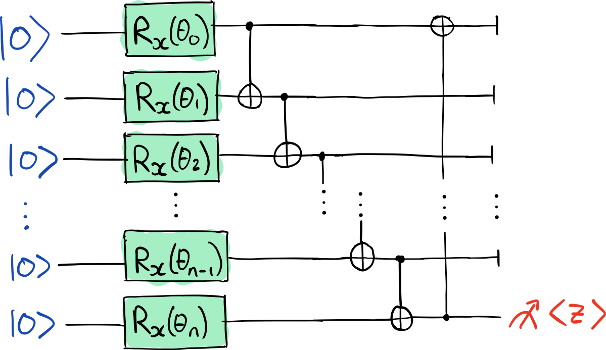

この回路では、25個の量子ビットのそれぞれに制御可能な回転ゲートがあります。最後に CNOT ゲートを追加し、量子ビットをエンタングルさせます。全体として、この回路には25の学習可能なパラメーターがあります。実用的な問題とは特に関係ありませんが、この回路をリモートデバイスとローカルデバイスの比較のためのテストベッドとして使用しましょう。

次のステップでは、上記の回路を PennyLane QNode に変換し、実行のために回路をデバイスにバインドします。

In [5]:
qnode_remote = qml.QNode(circuit, dev_remote)
qnode_local = qml.QNode(circuit, dev_local)

<div class="alert alert-block alert-info">
 <b>注:</b> 上記では、<code>qml.QNode</code> を使用して回路を変換します。以前のチュートリアルでは、<code>@qml.qnode()</code> デコレータが使用されているよう見覚えがあるかもしれません。これらのアプローチは交換可能ですが、同じ回路を異なるデバイスにペアリングできるため、ここでは <code>Qml.QNode</code> を使用しています。
</div>

それでは、2 つのデバイス間の実行時間を比較してみましょう。

In [6]:
import time

params = np.random.random(wires)

次のセルでは、SV1 で 1 つの回路が実行されます。

In [7]:
t_0_remote = time.time()

qnode_remote(params)

t_1_remote = time.time()

In [8]:
t_0_local = time.time()

qnode_local(params)

t_1_local = time.time()

In [9]:
print("Execution time on remote device (seconds):", t_1_remote - t_0_remote)
print("Execution time on local device (seconds):", t_1_local - t_0_local)

Execution time on remote device (seconds): 3.818446397781372
Execution time on local device (seconds): 27.371450662612915


いい感じですね！これらの計測時間は、大きな量子ビット数のシミュレーションに SV1 を使用する利点を示唆しています。一般に、シミュレーション時間は量子ビット数に応じて指数関数的に増加しますが、SV1 は高度に最適化され、AWS のリモートサーバー上で実行されます。これにより、この 25 量子ビットの例では SV1 がローカルシミュレータよりも優れたパフォーマンスを発揮します。リモートデバイスに表示される実際の時間は、AWS サーバーまでの距離などの要因によっても異なります。

<div class="alert alert-block alert-info">
<b>注</b> これらの実行時間を見ると、誰が何のためにローカルシミュレータを使うのか、疑問に思う方もいるでしょう。回路の量子ビットが少ない場合は、ローカルシミュレータの利用を検討する必要があります。この状況では、回路を AWS に送信するレイテンシーがシミュレーション時間よりも支配的になり、ローカルシミュレータの方が高速に動作します。
</div>

## 勾配計算のベンチマーク

次に、2 つのデバイス間の勾配計算時間を比較してみましょう。リモートデバイスをロードするときは、``parallel=True`` を設定することを忘れないでください。これにより、勾配計算に必要な複数のデバイスを SV1 で並行実行して実行できるため、リモートデバイスの速度がはるかに高速になることが期待されます。

In [10]:
d_qnode_remote = qml.grad(qnode_remote)
d_qnode_local = qml.grad(qnode_local)

次のセルでは、SV1 で 51 個の回路が (並列に) 実行されます。各パラメータに関して偏微分を評価するには、回路を 2 回実行する必要があります。したがって、25 のパラメータに対して 50 回路の実行があります。最後の回路の実行は、勾配が計算される前の QNode の順伝播評価によるものです。

In [11]:
t_0_remote_grad = time.time()

d_qnode_remote(params)

t_1_remote_grad = time.time()

<div class="alert alert-block alert-warning">
<b>注:</b> ハードウェアによっては、次のセルの実行に 15 分以上かかる場合があります。待てるときだけコメントを外してください。
</div>

In [12]:
# t_0_local_grad = time.time()

# d_qnode_local(params)

# t_1_local_grad = time.time()

In [13]:
print("Gradient calculation time on remote device (seconds):", t_1_remote_grad - t_0_remote_grad)
# print("Gradient calculation time on local device (seconds):", t_1_local_grad - t_0_local_grad)

Gradient calculation time on remote device (seconds): 21.190669536590576


ローカルデバイスの実行を忍耐強く待てば、約 15 分以上と表示されるはずです！これを、SV1 の勾配の計算に費やした 1 分未満と比較してください。すなわちこれが、並列化による恩恵です。

``parallel=False`` で SV1 を実行するとどうなるでしょう？所要時間は約 3 分で、ローカルデバイスよりは高速ですが、SV1 を並列で実行するよりはるかに遅くなります。

<div class="alert alert-block alert-info">
<b>次のステップは？</b> PennyLane と Braket を使って問題を解く方法を、いくつかのアプリケーションについて調べてみましょう。例えば <a href="./2_Graph_optimization_with_QAOA.ipynb">グラフの最適化</a> や <a href="./3_Quantum_chemistry_with_VQE.ipynb">量子化学の問題</a> のノートブックが用意されています。
</div>

In [14]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 52}, 'execution_duration': datetime.timedelta(seconds=18, microseconds=92000), 'billed_execution_duration': datetime.timedelta(seconds=156)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.195 USD
